<a href="https://colab.research.google.com/github/zinebzannouti/DL-CarClassificationWithFlask/blob/main/CNN_CASE_STUDY_SOLUTION/Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Web Scrapping Using Selenium**

Install Selenium , chromdriver

In [ ]:
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver


In [ ]:
!pip install webdriver_manager

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 6.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.12
    Uninstalling urllib3-1.26.12:
      Successfully uninstalled urllib3-1.26.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
selenium 4.6.0 requires urllib3[socks]~=1.26, but you have urllib3 1.25.11 which is incompatible.


Import libraries

In [ ]:
import os
import selenium
from selenium import webdriver
import time
from PIL import Image
import io
import requests
from webdriver_manager.chrome import ChromeDriverManager

In [ ]:
#Install driver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: use options instead of chrome_options
  


In [ ]:
def scroll_to_end(driver):
     
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(5)

In [ ]:
def getImageUrls(name,totalImgs,driver):
   
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"
    driver.get(search_url.format(q=name))

    img_urls = set()
    img_count = 0
    results_start = 0  
    
    while(img_count<totalImgs): #Extract actual images now
        
        scroll_to_end(driver)
        
        thumbnail_results = driver.find_elements("xpath","//img[contains(@class,'Q4LuWd')]")
        totalResults=len(thumbnail_results)
        print(f"Found: {totalResults} search results. Extracting links from {results_start}:{totalResults}")
        
        for img in thumbnail_results[results_start:totalResults]:
            
            img.click()
            time.sleep(2)
            actual_images = driver.find_elements("css selector",'img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'https' in actual_image.get_attribute('src'):
                    img_urls.add(actual_image.get_attribute('src'))
            
            img_count=len(img_urls)
            
            if img_count >= totalImgs:
                print(f"Found: {img_count} image links")
                break
            else:
                print("Found:", img_count, "looking for more image links ...")                
                load_more_button = driver.find_element("css selector",".mye4qd")
                driver.execute_script("document.querySelector('.mye4qd').click();")
                results_start = len(thumbnail_results)
    return img_urls

In [ ]:
def downloadImages(folder_path,file_name,url):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - COULD NOT DOWNLOAD {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        
        file_path = os.path.join(folder_path, file_name)
        
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SAVED - {url} - AT: {file_path}")
    except Exception as e:

        print(f"ERROR - COULD NOT SAVE {url} - {e}")

In [ ]:

searchNames=['BMW 3 Series Wagon','PEUGEOT 208 II','RENAULT CLIO V','PEUGEOT 2008 II','DACIA SANDERO 3','CITROEN C3 Ill','RENAULT CAPTUR II','PEUGEOT 3008 II','TOYOTA YARIS','DACIA DUSTER 2','RENAULT TWINGO lll','RENAULT MEGANE IV','CITROEN C3 AIRCR','FIAT 500','TESLA MODEL 3','VOLKSWAGEN POLO VI','RENAULT ZOE','CITROEN CS AIRCR','PEUGEOT 5008 II','CITROEN C4 Ill','VOLKSWAGEN T-ROC','RENAULT ARKANA','HYUNDAI TUCSONlll','PEUGEOT 308 II','TOYOTA COROLLA','FORD PUMA','OPEL CORSA','TOYOTA C-HR','VOLKSWAGEN T-CROSS','MERCEDES CLASSE A']


In [ ]:
def saveInDestFolder(searchNames,destDir,totalImgs,driver):
    for name in list(searchNames):
        path=os.path.join(destDir,name)
        if not os.path.isdir(path):
            os.mkdir(path)
        print('Current Path',path)
        totalLinks=getImageUrls(name,totalImgs,driver)
        print('totalLinks',totalLinks)

        if totalLinks is None:
            print('images not found for :',name)
            continue
        else:
            for i, link in enumerate(totalLinks):
                file_name = f"{i:150}.jpg"
                downloadImages(path,file_name,link)
destDir=f'/content/drive/MyDrive/CarsData'
totalImgs=100
saveInDestFolder(searchNames,destDir,totalImgs,driver)

In [13]:
!pip install -q keras
!pip install pyunpack
!pip install efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D,BatchNormalization
from keras import optimizers
import efficientnet.keras as efn
from keras.preprocessing import image
from keras import backend as K
from keras.models import model_from_json
from keras.optimizers import Nadam
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import keras
from keras.models import load_model
from keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import scipy.io as sio
import os

In [15]:
batch_size = 32
input_shape = (240,240)
train_dir = '/content/drive/MyDrive/FrenchCarsSplit/train'
test_dir = '/content/drive/MyDrive/FrenchCarsSplit/val'

**Image Preprocessing and Data Augmentation**

In [16]:
#Define train and test datagen with ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        rotation_range=20.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=[0.9, 1.25],
        brightness_range=[0.5, 1.5],
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
#Define train and test generator
train_generator=train_datagen.flow_from_directory(train_dir,
class_mode="categorical",
target_size=input_shape,
batch_size=batch_size)
validation_generator=test_datagen.flow_from_directory(test_dir,
class_mode="categorical",
target_size=input_shape,
batch_size=batch_size)

Found 2280 images belonging to 30 classes.
Found 587 images belonging to 30 classes.


**Define The model**

*Here we will take the EfficientNetB3 model pretrained on the imagenet dataset and we will transfer the learning to our new model by freezing the EfficientNetB3 model and creating a new model on top.* 

In [18]:
#First instantiate a base model with pre-trained weights.
base_model = efn.EfficientNetB3(weights='imagenet', include_top=False)


In [19]:
#Create a new model on top.
#add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(32,activation='relu')(x)
x=BatchNormalization()(x)
predictions = Dense(30,activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam',
loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   1080        ['input_2[0][0]']                
                                40)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   160         ['stem_conv[0][0]']              
                                40)                                                         

**Training The model**

In [20]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size + 1 ,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size + 1,
                    epochs=15,
                    verbose=1)

Epoch 1/15
72/72 [==============================] - 78s 867ms/step - loss: 3.6006 - accuracy: 0.0544 - val_loss: 3.4865 - val_accuracy: 0.0647
Epoch 2/15
72/72 [==============================] - 60s 827ms/step - loss: 3.2546 - accuracy: 0.1066 - val_loss: 3.1809 - val_accuracy: 0.1635
Epoch 3/15
72/72 [==============================] - 59s 831ms/step - loss: 2.8763 - accuracy: 0.1974 - val_loss: 2.4866 - val_accuracy: 0.2998
Epoch 4/15
72/72 [==============================] - 60s 822ms/step - loss: 2.4508 - accuracy: 0.3211 - val_loss: 2.2880 - val_accuracy: 0.3560
Epoch 5/15
72/72 [==============================] - 60s 825ms/step - loss: 2.1325 - accuracy: 0.4162 - val_loss: 2.1394 - val_accuracy: 0.3952
Epoch 6/15
72/72 [==============================] - 64s 883ms/step - loss: 1.7999 - accuracy: 0.5202 - val_loss: 1.9432 - val_accuracy: 0.4804
Epoch 7/15
72/72 [==============================] - 60s 826ms/step - loss: 1.5569 - accuracy: 0.5776 - val_loss: 1.3914 - val_accuracy: 0.5911

**Plot the Accuracy and the loss graphs**

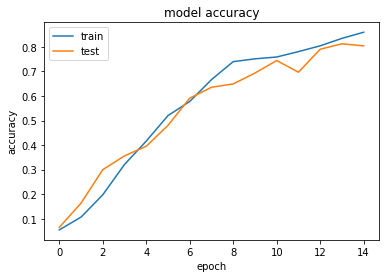

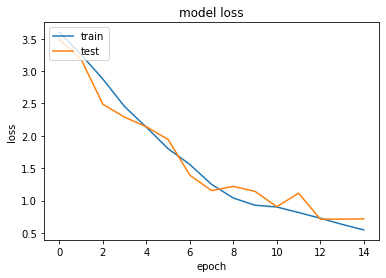

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Fine-tuning**

Once your model has converged on the new data, you can try to unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate.

This is an optional last step that can potentially give you incremental improvements. It could also potentially lead to quick overfitting -- keep that in mind.

It is critical to only do this step after the model with frozen layers has been trained to convergence. If you mix randomly-initialized trainable layers with trainable layers that hold pre-trained features, the randomly-initialized layers will cause very large gradient updates during training, which will destroy your pre-trained features.

It's also critical to use a very low learning rate at this stage, because you are training a much larger model than in the first round of training, on a dataset that is typically very small. As a result, you are at risk of overfitting very quickly if you apply large weight updates. Here, you only want to readapt the pretrained weights in an incremental way.

This is how to implement fine-tuning of the whole base model: 

In [22]:
# Unfreeze the base model
base_model.trainable = True

In [23]:
# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=Adam(1e-5),  # Very low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [24]:
# Train end-to-end
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.samples // batch_size + 1 ,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size + 1,
                    epochs=10,
                    verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
72/72 [==============================] - 76s 872ms/step - loss: 0.4719 - accuracy: 0.8785 - val_loss: 0.4916 - val_accuracy: 0.8603
Epoch 2/10
72/72 [==============================] - 60s 829ms/step - loss: 0.4639 - accuracy: 0.8882 - val_loss: 0.4261 - val_accuracy: 0.8739
Epoch 3/10
72/72 [==============================] - 60s 825ms/step - loss: 0.4426 - accuracy: 0.8855 - val_loss: 0.4044 - val_accuracy: 0.8773
Epoch 4/10
72/72 [==============================] - 60s 830ms/step - loss: 0.3928 - accuracy: 0.9105 - val_loss: 0.3963 - val_accuracy: 0.8790
Epoch 5/10
72/72 [==============================] - 60s 835ms/step - loss: 0.3726 - accuracy: 0.9079 - val_loss: 0.3902 - val_accuracy: 0.8790
Epoch 6/10
72/72 [==============================] - 60s 832ms/step - loss: 0.4005 - accuracy: 0.9083 - val_loss: 0.3861 - val_accuracy: 0.8842
Epoch 7/10
72/72 [==============================] - 60s 831ms/step - loss: 0.3605 - accuracy: 0.9189 - val_loss: 0.3815 - val_accuracy: 0.8842

In [25]:
#Save the model
model.save('model.h5')

**Confusion Matrix**

In [26]:
Y_pred = model.predict_generator(validation_generator, validation_generator.samples  // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')

print(classification_report(validation_generator.classes, y_pred))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Confusion Matrix
[[1 1 1 0 0 1 2 0 2 0 1 1 0 1 0 0 2 0 0 1 1 1 1 1 1 0 0 0 1 0]
 [0 1 0 0 2 1 0 1 0 0 1 1 0 1 1 2 0 0 1 0 0 1 0 1 0 1 1 1 1 1]
 [1 0 1 1 0 2 0 2 1 0 1 1 0 0 0 1 2 2 0 0 1 0 0 1 0 0 2 0 1 0]
 [0 1 1 1 0 1 0 0 1 1 0 2 1 0 0 0 1 0 0 0 2 1 0 0 1 2 1 0 1 2]
 [2 0 1 1 0 0 1 1 2 1 0 0 1 1 2 0 0 0 0 2 1 0 1 0 0 1 0 0 0 0]
 [2 1 1 0 1 1 1 2 0 0 1 1 0 1 0 1 0 0 0 1 0 1 2 0 0 2 0 0 0 1]
 [1 2 4 1 0 0 0 1 0 1 1 0 0 0 0 0 2 0 1 1 1 1 1 1 0 0 0 0 1 0]
 [2 0 0 0 0 2 1 1 1 0 1 1 1 1 0 1 2 0 0 1 2 1 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 2 0 0 0 1 1 0 1 1 2 1 2 0 0 0 0 1 1 0 1 1 1 1 1 1]
 [1 0 1 2 1 0 0 0 1 0 1 0 1 1 0 0 0 4 1 0 1 0 0 0 2 0 1 1 1 1]
 [0 1 0 0 0 0 2 0 0 0 2 0 1 1 0 0 0 0 3 2 1 0 0 0 4 1 1 0 1 0]
 [2 2 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 3 0 1 1 0 1 2 1 1 0 1 0 1]
 [1 0 0 0 0 1 1 0 1 0 2 1 0 0 2 1 1 1 1 1 0 0 0 2 1 0 0 1 0 1]
 [1 2 0 0 1 0 0 0 1 1 1 0 0 2 0 2 0 0 0 0 0 0 1 1 1 1 0 2 0 2]
 [0 0 0 0 1 0 0 0 2 1 3 1 0 0 0 3 0 0 1 0 0 3 1 0 0 0 0 1 2 0]
 [1 1 0 1 1 0 0 3 0 1 0 0 3 0 0 0 1 1 

In [27]:
cm=confusion_matrix(validation_generator.classes, y_pred)

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
category_names = sorted(os.listdir('/content/drive/MyDrive/FrenchCarsSplit/train'))

Normalized confusion matrix
[[0.05       0.05       0.05       0.         0.         0.05
  0.1        0.         0.1        0.         0.05       0.05
  0.         0.05       0.         0.         0.1        0.
  0.         0.05       0.05       0.05       0.05       0.05
  0.05       0.         0.         0.         0.05       0.        ]
 [0.         0.05263158 0.         0.         0.10526316 0.05263158
  0.         0.05263158 0.         0.         0.05263158 0.05263158
  0.         0.05263158 0.05263158 0.10526316 0.         0.
  0.05263158 0.         0.         0.05263158 0.         0.05263158
  0.         0.05263158 0.05263158 0.05263158 0.05263158 0.05263158]
 [0.05       0.         0.05       0.05       0.         0.1
  0.         0.1        0.05       0.         0.05       0.05
  0.         0.         0.         0.05       0.1        0.1
  0.         0.         0.05       0.         0.         0.05
  0.         0.         0.1        0.         0.05       0.        ]
 [0.     

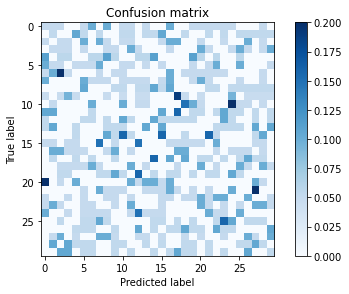

In [31]:
plot_confusion_matrix(cm, category_names,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)